In [1]:
import sys
import os
import importlib

import numpy as np
import scipy
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import pyemma
import mdtraj as md

# import ivac
import extq
from extq.stop import forward_stop, backward_stop

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2

# Load data

In [5]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0] # 0.1 ns lag time

# currents
j_du_ds = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/j_du_ds_3.npy", allow_pickle=True)[
    6
]  # 10 ns lag time

# MFPT
mfpt = np.load(f"{DATA_DIR}/mfpt_lag500_mem3_bigstate.npy", allow_pickle=True)

In [6]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [7]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

# S4 helix forward, backward committors for activation and deactivation

In [8]:
dist_trajs_delay = [t[:-lag, 0] for t in cv_trajs]
rot_trajs_delay = [t[:-lag, 1] for t in cv_trajs]
w_delay = [w[:-lag] for w in weights]

qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

# Violin plots of S4 helix CVs

In [9]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

In [10]:
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.15, hi=0.85)

In [11]:
steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.1f}")
    else:
        steplabels.append("")

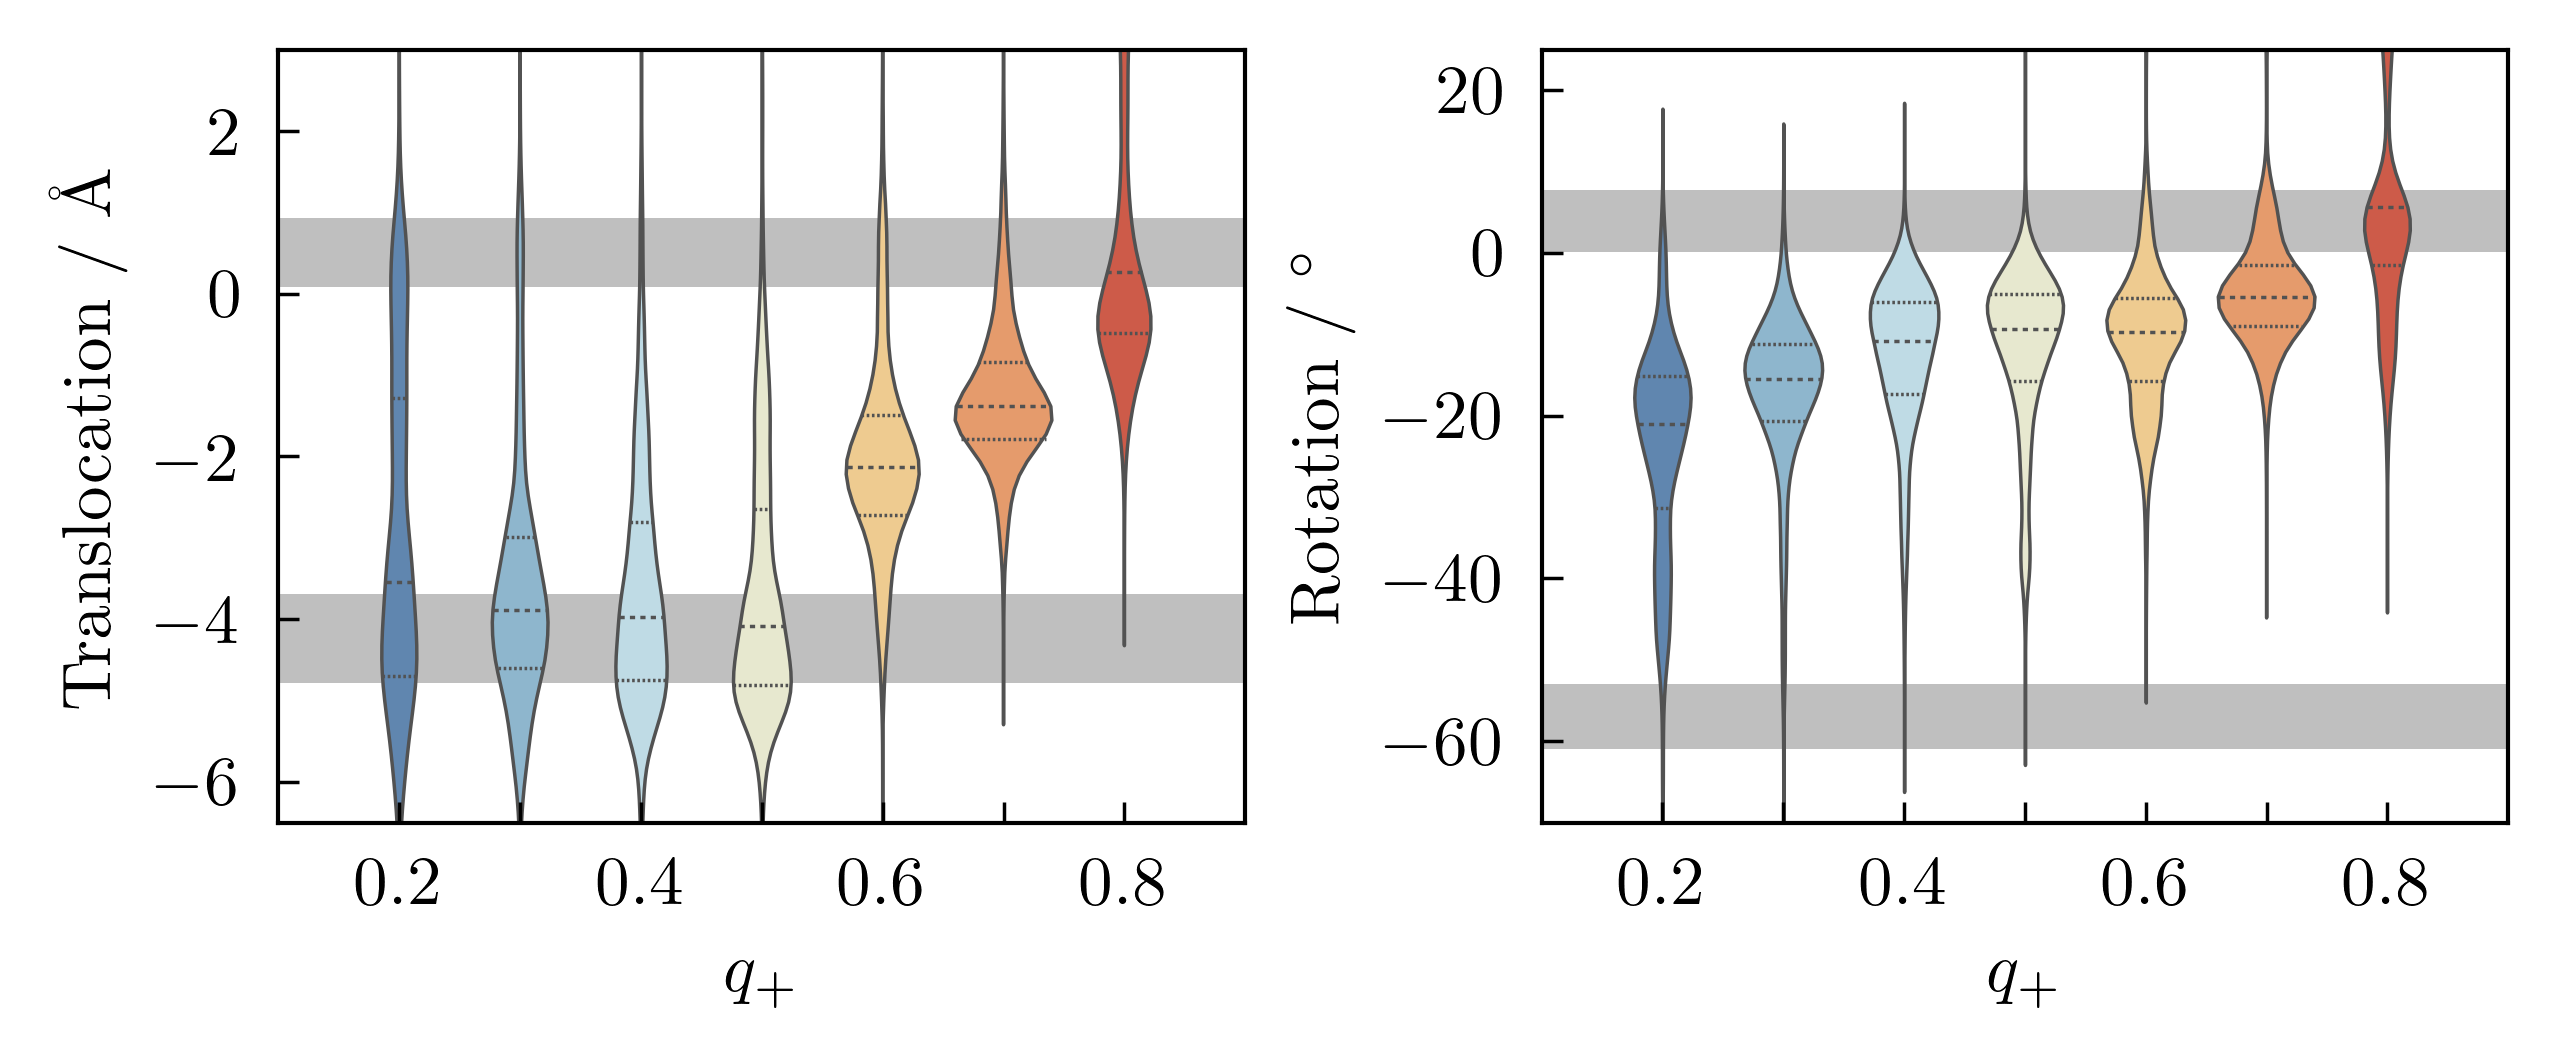

In [14]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(5, 2.0), dpi=500, constrained_layout=True, sharex=True)
sns.violinplot(ax=ax0, data=[cv_arr[inds, 0] for inds in q_inds], scale='area', bw=0.1, inner="quartile", palette='diverging', orient="v", linewidth=0.5)

ax0.set_xticklabels(steplabels)
ax0.set_xlabel("$q_+$")
ax0.set_ylabel("Translocation / Å")
ax0.set_ylim([-6.5, 3])
ax0.axhspan(-4.240 - 0.55, -4.24 + 0.55, color='grey', alpha=0.5, zorder=0, ec=None)
ax0.axhspan( 0.506 - 0.42, 0.506 + 0.42, color='grey', alpha=0.5, zorder=0, ec=None)
ax0.set_xlim([-1, 7])
# ax0.invert_yaxis()

sns.violinplot(ax=ax1, data=[cv_arr[inds, 1] for inds in q_inds], scale='area', bw=0.1, inner="quartile", palette='diverging', orient="v", linewidth=0.5)
ax1.set_xticklabels(steplabels)
ax1.set_xlabel("$q_+$")
ax1.set_ylabel("Rotation / $^\circ$")
ax1.set_ylim([-70, 25])
ax1.axhspan(-56.95 - 4, -56.95 + 4, color='grey', alpha=0.5, zorder=0, ec=None)
ax1.axhspan(3.94 - 3.8, 3.94 + 3.8, color='grey', alpha=0.5, zorder=0, ec=None)
ax1.set_xlim([-1, 7])
# ax1.invert_yaxis()
plt.savefig("../../fig/paper/ds_violins.pdf", bbox_inches='tight')

# Currents

In [15]:
# color arrows from transparent to white depending on magnitude
rgb = 255 / 256
colors = [(rgb, rgb, rgb, c) for c in np.linspace(0.1, 1, 100)]
cmapwhite = mpl.colors.LinearSegmentedColormap.from_list("white", colors)

In [16]:
rgb_black = 1 / 256
colors_black = [(rgb_black, rgb_black, rgb_black, c) for c in np.linspace(0.05, 1, 100)]
cmapblack = mpl.colors.LinearSegmentedColormap.from_list("black", colors_black)
mpl.colormaps.register(cmapblack, force=True)

In [17]:
def plot_pmf_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    n_pmf,
    clines,
    cm_pmf="macaw",
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    xlim = np.linspace(xmin, xmax, n_pmf)
    ylim = np.linspace(ymin, ymax, n_pmf)
    centerx = (xlim[1:] + xlim[:-1]) / 2
    centery = (ylim[1:] + ylim[:-1]) / 2

    pmf = extq.projection.density2d(cv1, cv2, weights, xlim, ylim)

    if ax is None:
        ax = plt.gca()
    ax, pc = plotting.plot_pmf(
        ax, pmf, xlim, ylim, units="kcal", clines=clines, cmap=cm_pmf
    )
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned ** 2 + jy_binned ** 2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.007,
        cmap=cm_j,
        headwidth=2.5,
        headlength=2.5,
        headaxislength=2.5,
        scale=20,
        scale_units="width",
        zorder=5,
    )

    return ax, pc, quiv

In [18]:
def plot_current(
    cv1,
    cv2,
    j,
    weights,
    xmin,
    xmax,
    ymin,
    ymax,
    n,
    cm_j=cmapwhite,
    ax=None,
):
    xlim_flux = np.linspace(xmin, xmax, n + 1)
    ylim_flux = np.linspace(ymin, ymax, n + 1)
    centerx_flux = (xlim_flux[1:] + xlim_flux[:-1]) / 2
    centery_flux = (ylim_flux[1:] + ylim_flux[:-1]) / 2
    X, Y = np.meshgrid(centerx_flux, centery_flux)

    if ax is None:
        ax = plt.gca()
    # KDE bin fluxes
    jx_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 0]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )
    jy_binned, _, _ = util.kdesum2d(
        np.concatenate(cv1),
        np.concatenate(cv2),
        np.concatenate(j[:, 1]),
        nx=n,
        ny=n,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
    )

    # set color/magnitude of arrow equal to L2 norm od KDEd fluxes
    col = (jx_binned ** 2 + jy_binned ** 2) ** 0.5
    # normalize arrow so same
    quiv = ax.quiver(
        X,
        Y,
        (jx_binned / col).T,
        (jy_binned / col).T,
        col.T,
        pivot="middle",
        width=0.008,
        cmap=cm_j,
        headwidth=4,
        headlength=4,
        headaxislength=3,
        scale=15,
        scale_units="width",
        zorder=5,
    )

    return ax, quiv

In [19]:
centroids = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")

/scratch/local/jobs/278587/ipykernel_578685/2946474533.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8005baee50> has a label of '_' which cannot be automatically added to the legend.
  f.legend(
/scratch/local/jobs/278587/ipykernel_578685/2946474533.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7f8005bc05e0> has a label of '_' which cannot be automatically added to the legend.
  f.legend(
/scratch/local/jobs/278587/ipykernel_578685/2946474533.py:28: RuntimeWarning: divide by zero encountered in log
  diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol
/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


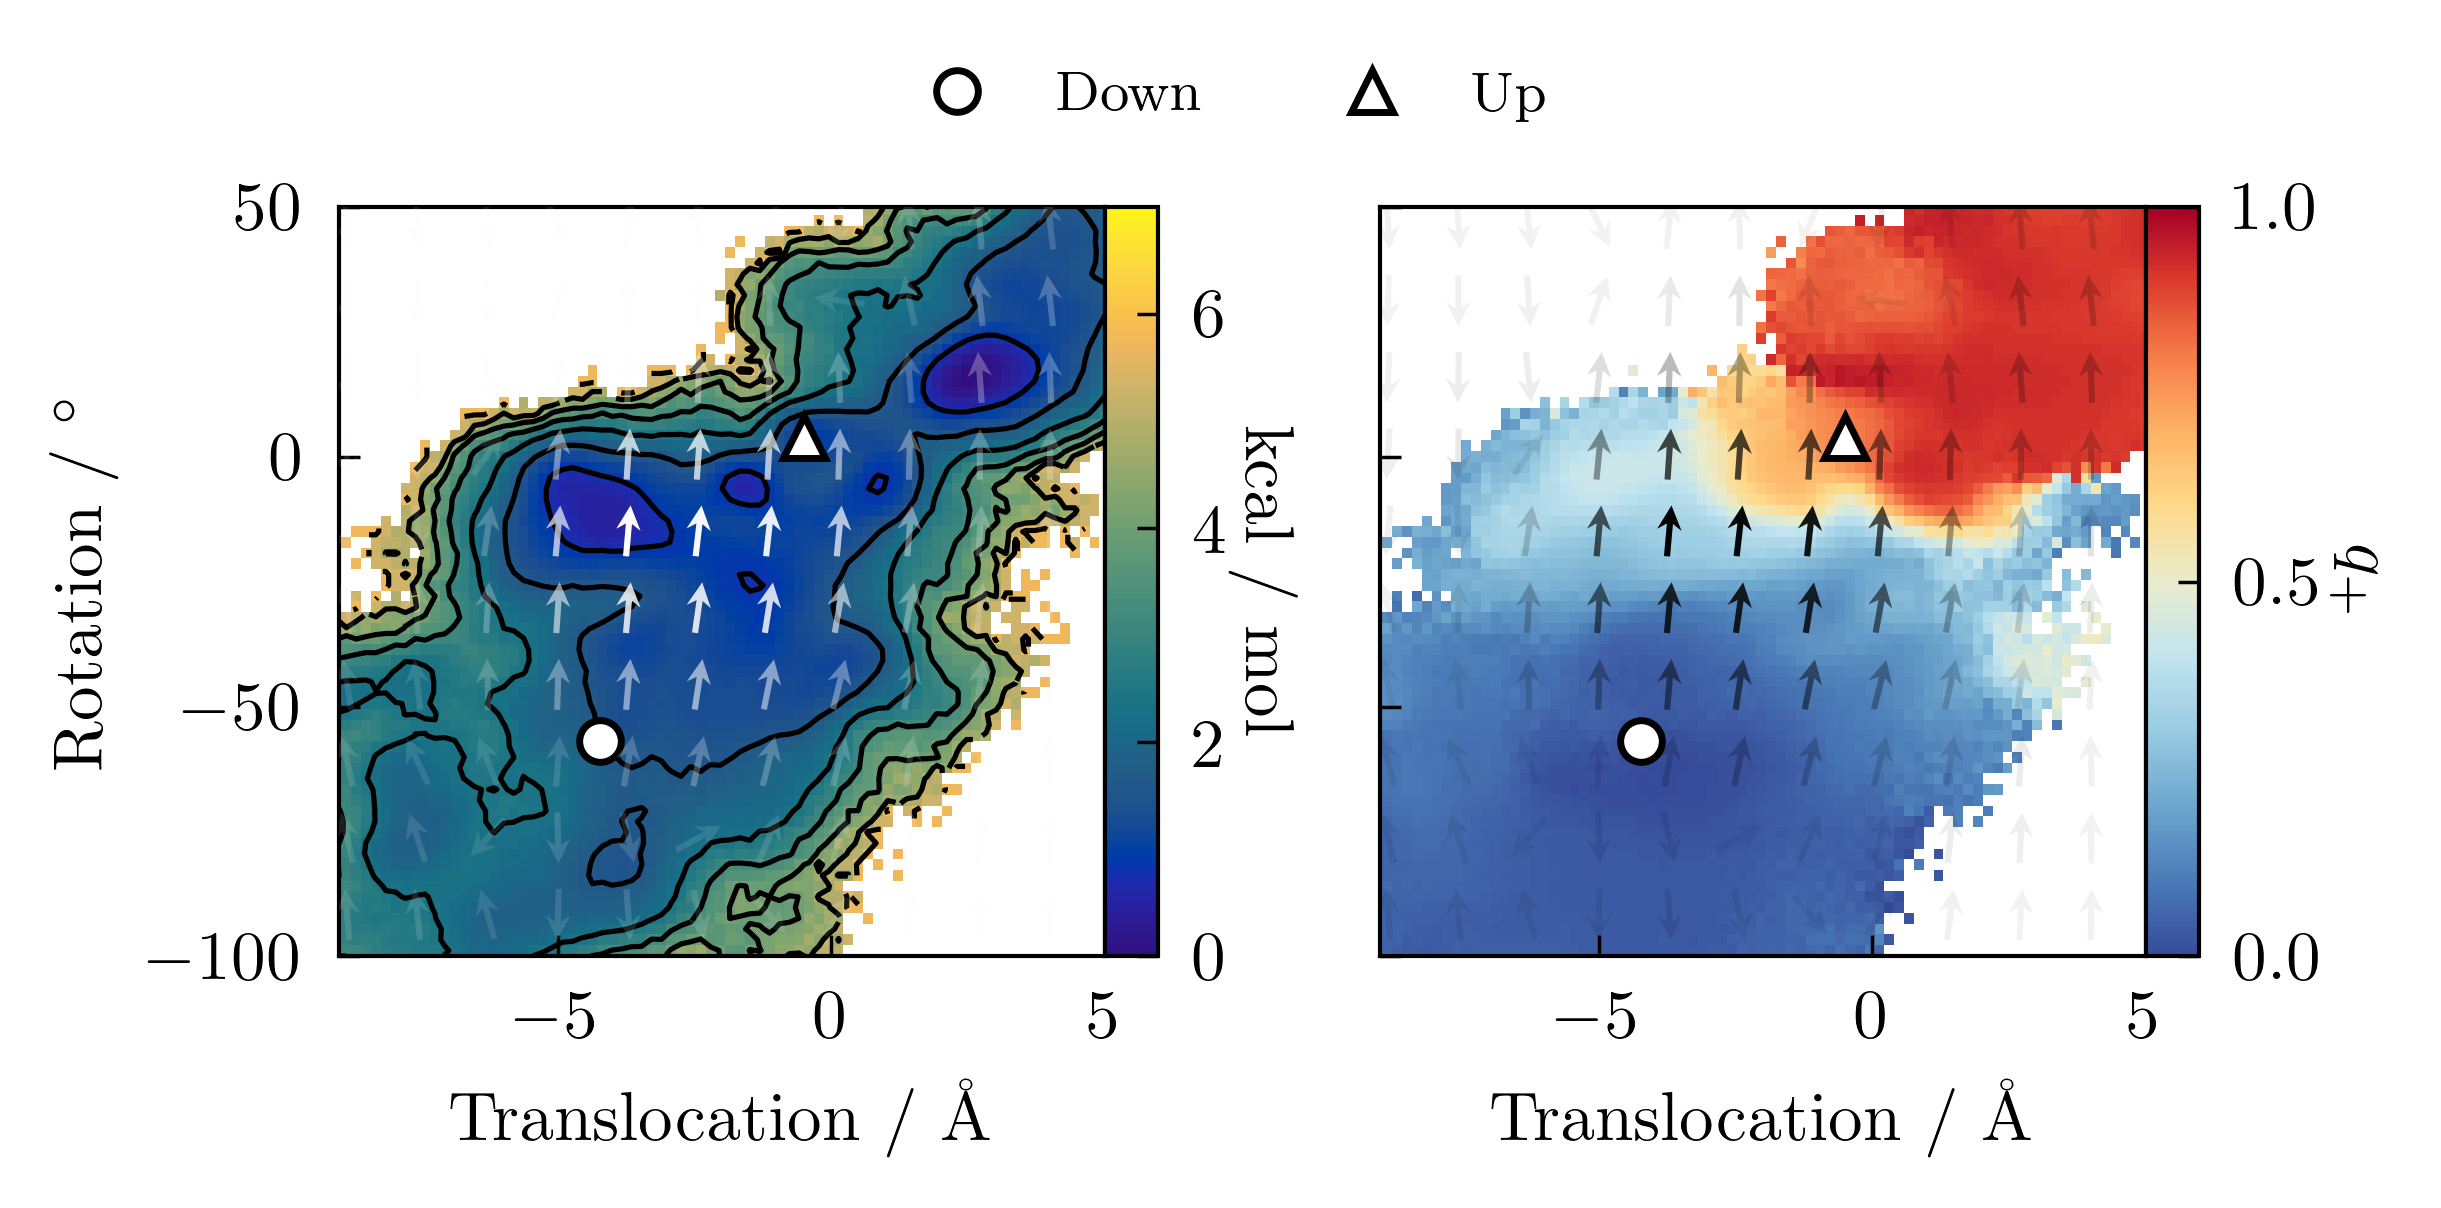

In [21]:
vmin, vmax = 0, 7
clines = np.linspace(
    vmin, vmax, (vmax - vmin) + 1
)  # contour lines spaced every 1 kcal/mol

f, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(5, 2.25), dpi=500)
plotting.plot_models(ax0, centroids, ms=6, zorder=5)
plotting.plot_models(ax1, centroids, ms=6, zorder=5)
f.legend(
    bbox_to_anchor=(0.5, 1.01),
    loc="center",
    ncol=4,
    labels=["_", "Down", "Up", "_"],
    fontsize=8
)

# PMF + current
dist_trajs = [t[:, 0] for t in cv_trajs]
rot_trajs = [t[:, 1] for t in cv_trajs]
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2

pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights, xe, ye)
offset = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = (-np.log(pmf) - offset) * 0.593  # convert to kcal/mol

pc0 = ax0.pcolormesh(
    xcent, ycent, diff.T, cmap="macaw", vmin=vmin, vmax=vmax, rasterized=True
)
ax0.contour(xcent, ycent, diff.T, colors="black")
cb = pplt.colorbar(pc0, ax=ax0)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
# cb.set_ticks(np.linspace(0, 6, 4))
# current
plot_current(dist_trajs, rot_trajs, j_du_ds, weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapwhite, ax=ax0)

# committor + current
q_dens = extq.projection.average2d(
    dist_trajs_delay, rot_trajs_delay, qp_delay, w_delay, xe, ye
)
# plot committors
levels = np.linspace(0, 1.0, 51)
pc1 = ax1.pcolormesh(
    xcent, ycent, q_dens.T, cmap="diverging", vmin=0, vmax=1, rasterized=True
)
cb1 = pplt.colorbar(pc1, ax=ax1)
cb1.set_label("$q_+$", rotation=-90, labelpad=10)
cb1.set_ticks(np.linspace(0, 1, 3))
plot_current(dist_trajs, rot_trajs, j_du_ds, weights, xmin, xmax, ymin, ymax, 14, cm_j=cmapblack, ax=ax1)


for ax in (ax0, ax1):
    ax.set(xlim=[-9, 5], ylim=[-100, 50])
    ax.set_xlabel("Translocation / Å")
    ax.set_ylabel("Rotation / $^\circ$")
    ax.label_outer()
plt.tight_layout()
plt.savefig("../../fig/paper/ds_pmf_q_j.pdf", bbox_inches='tight')

# MFPT

In [20]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# Any points less than
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
# down_ids_square = (dist < -4.24) & (rot < -56.95)
zero = np.zeros_like(dist)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
dist_ax_up = np.minimum(dist + 0.506, zero) / 0.84
rot_ax_up = np.minimum(rot - 3.94, zero) / 7.6
up_ids = ((dist_ax_up**2 + rot_ax_up**2) < 1) & (sb1 < 0.5) & (sb3 < 1.1) & (sb4 < 0.75) & (sb5 < 0.6)
up_ids_alt = (dist > 0.334) & (rot > 11.5) & ~up_ids
up_ids = up_ids | up_ids_alt

In [15]:
models = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in divide
  return numer / denom


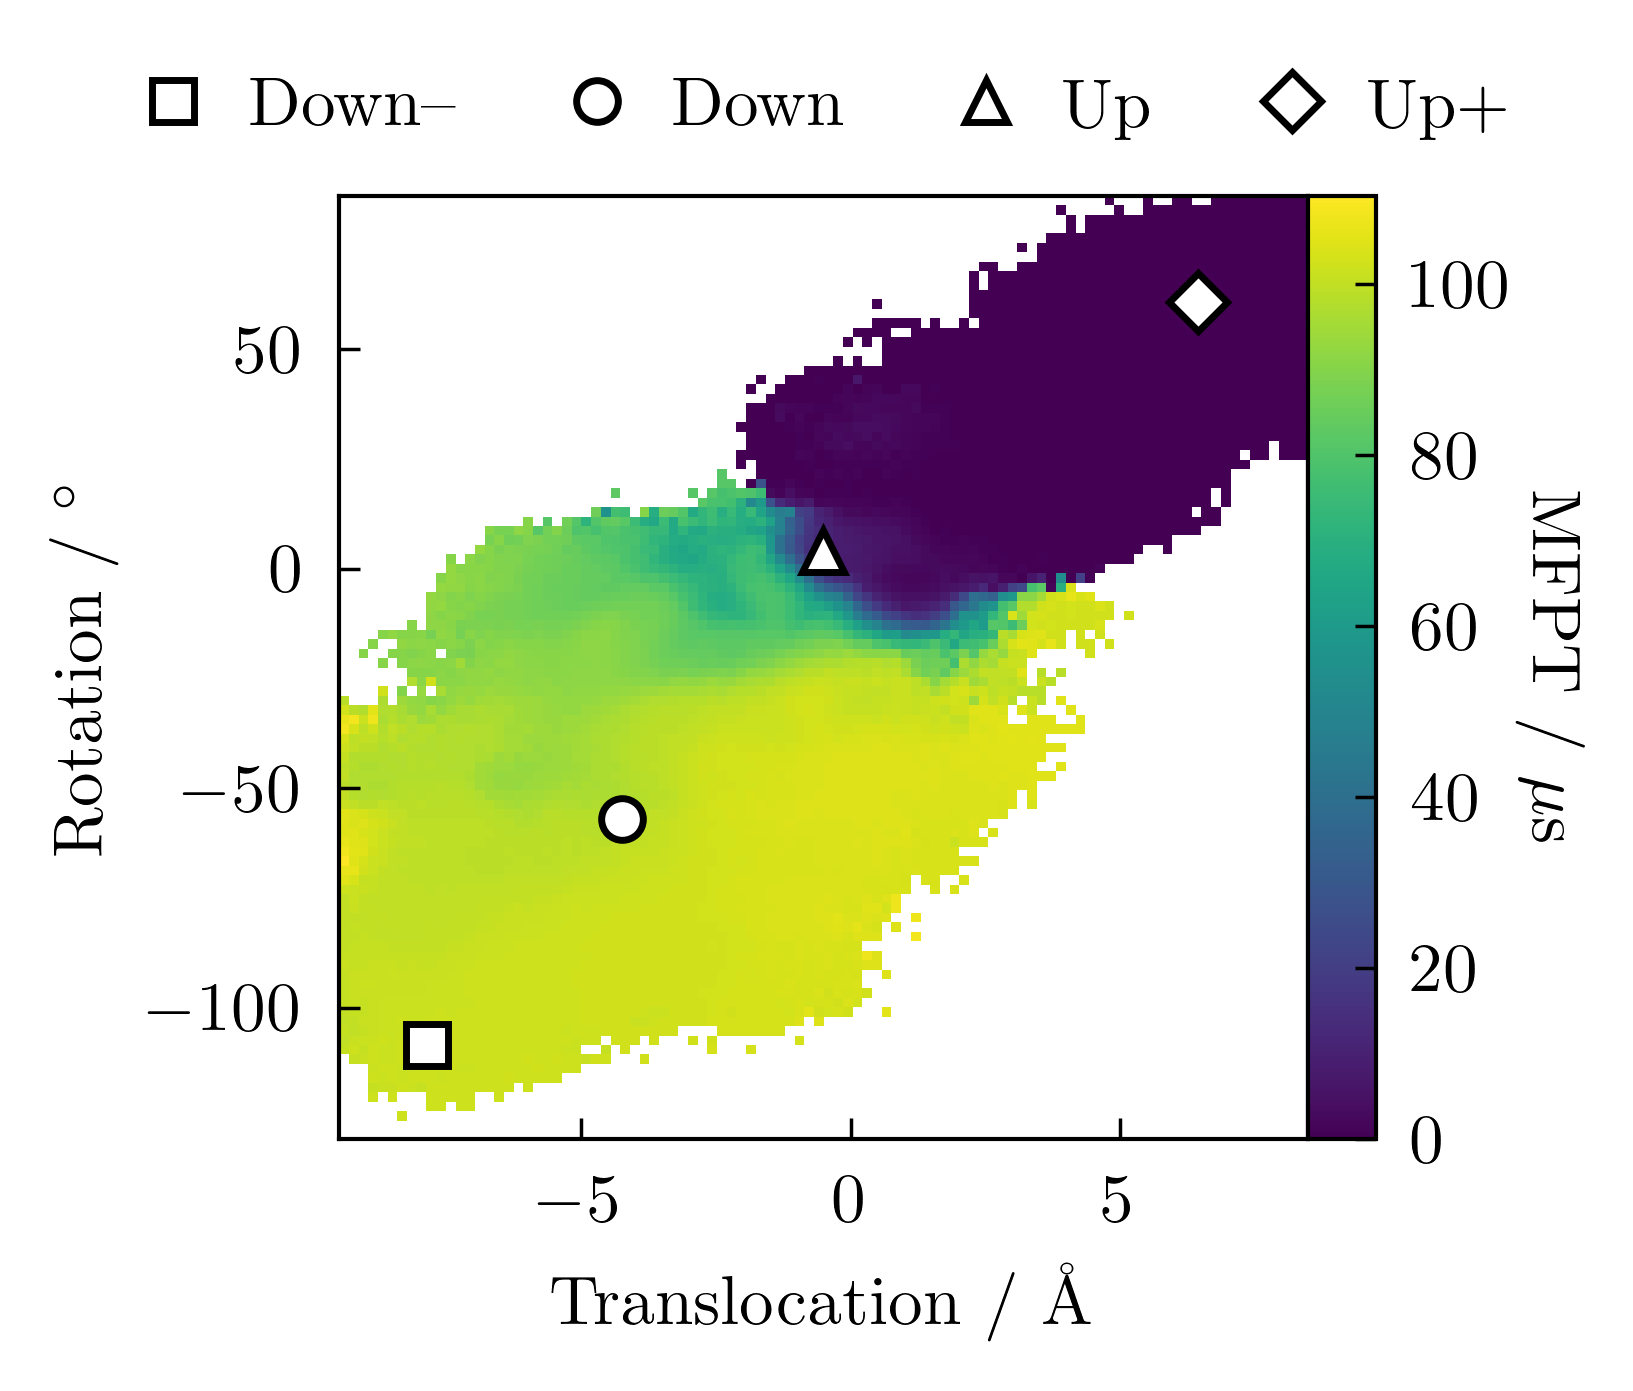

In [19]:
fig = plt.figure(figsize=(2.5, 2.5), dpi=500)
ax = plt.gca()
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
xcent = (xe[1:] + xe[:-1]) / 2
ycent = (ye[1:] + ye[:-1]) / 2
vmin, vmax = 0, 1

dist_trajs = [t[:-lag, 0] for t in cv_trajs]
rot_trajs = [t[:-lag, 1] for t in cv_trajs]
w_delay = [t[:-lag] for t in weights]
mfpt_delay = []
for d, t in zip(in_domain, mfpt):
    stop_times = np.minimum(np.arange(lag, len(d)), extq.stop.forward_stop(d)[:-lag])
    mfpt_delay.append(t[stop_times])
mfpt_bin = extq.projection.average2d(dist_trajs, rot_trajs, mfpt_delay, w_delay, xe, ye)
pc = ax.pcolormesh(xcent, ycent, mfpt_bin.T * 0.0001, vmin=0, rasterized=True)
cb = pplt.colorbar(pc, ax=ax)
cb.set_label(f"MFPT / $\\mu$s", rotation=-90, labelpad=10)

plotting.plot_models(ax, models, ms=6, zorder=5)
ax.set_xlabel("Translocation / Å")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
fig.legend(
    bbox_to_anchor=(0.5, 0.95),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    handletextpad=0.1,
    columnspacing=1.0,
)
plt.savefig("../../fig/paper/dq_mfpt.pdf", bbox_inches='tight')

In [23]:
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[8]

In [24]:
mfpt_down = np.concatenate(mfpt)[down_ids]
weight_down = np.concatenate(weights)[down_ids]
print(np.mean(mfpt_down) * 0.0001)
print(np.mean(mfpt_down * weight_down) * 0.0001 / np.mean(weight_down))

99.36676980444615
99.54283551474025
